In [62]:
!pip install requests pandas numpy geopandas seaborn matplotlib shapely

In [63]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely import Point
from joblib import Memory

In [3]:
cachedir = './joblib_cache'
memory = Memory(cachedir, verbose=0)

In [4]:
API_key = '57c26501ddcc34b05931d602c9bde30020f36ab4'
raw_data_dir = "../data/raw/"
processed_data_dir = "../data/processed/"

# Klamath County - North Ridge Estates

## Economic Indicators

In [7]:
@memory.cache
def acs_df_request(params: dict, year: tuple, filename: str) -> pd.DataFrame:
    all_data = []
    
    for year in np.arange(*year):
        url = f'https://api.census.gov/data/{year}/acs/acs5'
        response = requests.get(url, params=params)
        data = response.json()
        df = pd.DataFrame(data[1:], columns = data[0])
        df['year'] = year
        all_data.append(df)
    
    acs_df = pd.concat(all_data, ignore_index = True)
    acs_df.to_csv(raw_data_dir + filename)
    return acs_df

In [8]:
#iterates through ac5 data,
# I am filtering through Oregon and cities
params = {
    'get': 'NAME,B19013_001E',
    'for': 'place:*',
    'in': 'state:41',
    'key': API_key}
acs_df = acs_df_request(params, (2013, 2024), "acs-2013-2023-oregon-cities-income.csv")
acs_df.tail()

,NAME,B19013_001E,state,place,year
4342,"Woodburn city, Oregon",67469,41,83750,2023
4343,"Wood Village city, Oregon",72404,41,83950,2023
4344,"Yachats city, Oregon",70000,41,84200,2023
4345,"Yamhill city, Oregon",121250,41,84250,2023
4346,"Yoncalla city, Oregon",55000,41,84600,2023


In [9]:
#data cleaning

#Im renaming the column name to median household income in the past 12months
median_household = acs_df.rename(columns = {'B19013_001E':'Median Household Income'})
median_household.head(5)

#im turning median income into integers since they're strings
median_household['Median Household Income'] = pd.to_numeric(median_household['Median Household Income'], errors ='coerce')
median_household['year'] = pd.to_numeric(median_household['year'], errors ='coerce')

#getting rid of na values or negative values
invalid_count = (median_household['Median Household Income'] <= 0).sum()
total_count = len(median_household)
print(f"Invalid values: {invalid_count} ({invalid_count / total_count:.2%} of total)")

median_household = median_household[median_household['Median Household Income'] > 0]

#grouping by year to get avg income over time (Hermiston city)
median_household_herm = median_household[median_household['NAME'] == 'Hermiston city, Oregon']
#grouped_herm = median_household_herm.groupby('year')[['Median Household Income']].mean()
#grouped_herm = grouped_herm.reset_index()
grouped_herm = median_household_herm

#grouping by year to get avg income over time (Klamath Falls-near site)
median_household_kla = median_household[median_household['NAME'] == 'Klamath Falls city, Oregon']
#grouped_kla = median_household_kla.groupby('year')[['Median Household Income']].mean()
#grouped_kla = grouped_kla.reset_index()
grouped_kla = median_household_kla

Invalid values: 346 (7.96% of total)


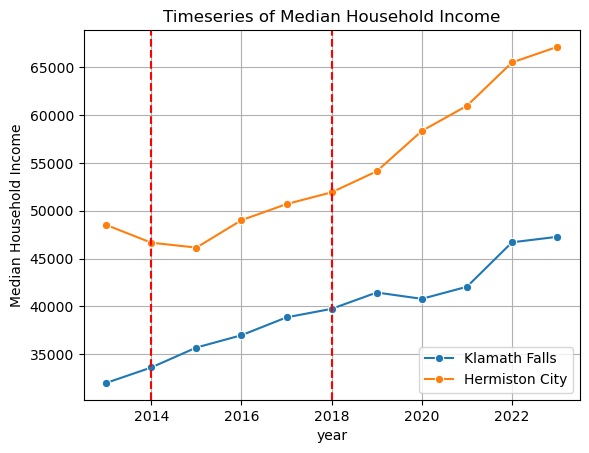

In [10]:
sns.lineplot(data = grouped_kla, x = 'year', y = 'Median Household Income', marker = 'o', label = 'Klamath Falls')
sns.lineplot(data = grouped_herm, x = 'year', y = 'Median Household Income', marker = 'o', label = 'Hermiston City')

plt.title('Timeseries of Median Household Income')
plt.legend()
plt.grid(True)
plt.axvline(x=2014, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig("../visualizations/city-comparison-income-2013-2023-plot.jpeg")
plt.show()

## Demographic Indicators

In [11]:
#iterates through ac5 data,
# I am filtering through Oregon and cities

params_ethnicity = {
    'get': 'NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E',
    'for': 'place:*',
    'in': 'state:41',
    'key': API_key}

ethnicity_df = acs_df_request(params_ethnicity, (2013, 2024), "acs-2013-2023-oregon-cities-ethnicity.csv")
ethnicity_df.tail()

,NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E,state,place,year
4342,"Woodburn city, Oregon",26845,16813,13209,84,241,41,83750,2023
4343,"Wood Village city, Oregon",4611,2299,2513,28,89,41,83950,2023
4344,"Yachats city, Oregon",881,34,801,5,1,41,84200,2023
4345,"Yamhill city, Oregon",1179,114,1068,0,50,41,84250,2023
4346,"Yoncalla city, Oregon",1106,40,973,0,3,41,84600,2023


In [12]:
ethnicity_df = ethnicity_df.rename(columns ={
    'B03001_001E': 'Total_Pop',
    'B03003_003E': 'Hispanic_or_Latino',
    'B02001_002E': 'White_alone',
    'B02001_003E': 'Black_alone',
    'B02001_005E': 'Asian_alone'
})

eth_column = ['Total_Pop','Hispanic_or_Latino','White_alone','Black_alone','Asian_alone']
for i in eth_column:
    if i in ethnicity_df.columns:
        ethnicity_df[i] = pd.to_numeric(ethnicity_df[i], errors ='coerce')
ethnicity_df.to_csv(processed_data_dir + "acs-2013-2023-oregon-cities-ethnicity-processed.csv")
Klamath_falls_ethnicity = ethnicity_df[ethnicity_df['NAME'] == 'Klamath Falls city, Oregon']
Klamath_falls_ethnicity.head(5)

,NAME,Total_Pop,Hispanic_or_Latino,White_alone,Black_alone,Asian_alone,state,place,year
96,"Klamath Falls city, Oregon",21026,2811,17864,218,427,41,39700,2013
712,"Klamath Falls city, Oregon",21165,2512,18006,311,339,41,39700,2014
903,"Klamath Falls city, Oregon",21261,2852,18217,301,312,41,39700,2015
1406,"Klamath Falls city, Oregon",21322,2971,18369,275,201,41,39700,2016
1577,"Klamath Falls city, Oregon",21113,2790,18039,394,213,41,39700,2017


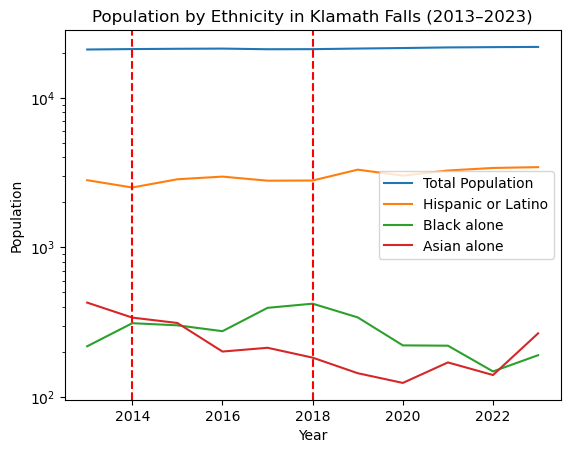

In [13]:
# ethnicity_log = np.log10(Klamath_falls_ethnicity[['Hispanic_or_Latino','White_alone','Black_alone','Asian_alone']])
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Total_Pop', label='Total Population')
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Hispanic_or_Latino',label='Hispanic or Latino')
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Black_alone', label='Black alone')
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Asian_alone', label='Asian alone')

plt.title('Population by Ethnicity in Klamath Falls (2013–2023)')
plt.ylabel('Population')
plt.xlabel('Year')
plt.legend()
plt.yscale('log')
plt.axvline(x=2014, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig("../visualizations/klamath-falls-city-ethnicity-2013-2023-plot.jpeg")
plt.show()


In [14]:
hermiston_city_ethnicity = ethnicity_df[ethnicity_df['NAME'] == "Hermiston city, Oregon"]
hermiston_city_ethnicity = hermiston_city_ethnicity.melt(id_vars="year", value_vars=["Total_Pop", "Hispanic_or_Latino", "Black_alone", "Asian_alone"])
hermiston_city_ethnicity.head()

,year,variable,value
0,2013,Total_Pop,16866
1,2014,Total_Pop,17031
2,2015,Total_Pop,17121
3,2016,Total_Pop,17150
4,2017,Total_Pop,17241


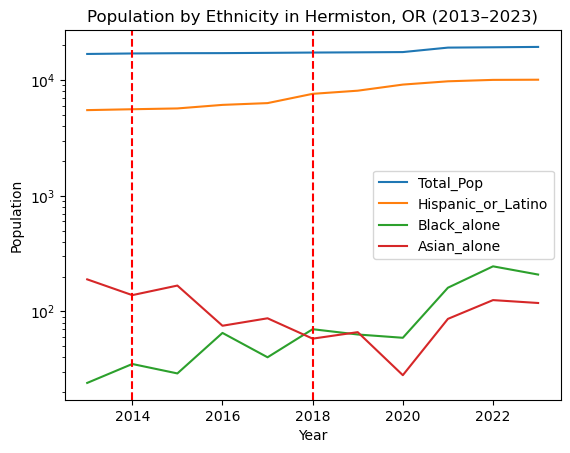

In [15]:
sns.lineplot(data=hermiston_city_ethnicity, x='year', y='value', hue='variable', legend="full")
# sns.lineplot(data=hermiston_city_ethnicity, x='year', y='Black_alone', label='Black alone')
# sns.lineplot(data=hermiston_city_ethnicity, x='year', y='Asian_alone', label='Asian alone')

plt.title('Population by Ethnicity in Hermiston, OR (2013–2023)')
plt.ylabel('Population')
plt.xlabel('Year')
plt.legend()
plt.yscale('log')
plt.axvline(x=2014, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig("../visualizations/hermiston-city-ethnicity-2013-2023-plot.jpeg")
plt.show()

## Mapping Basics

In [28]:
params_tract = {
    'get': 'GEO_ID,B19013_001E,B25008_002E,B25008_003E',
    'for': ['tract:*', 'county:035'],
    'in': ['state:41', 'county:035'],
    'key': API_key}
klamathCountyTractsIncome = acs_df_request(params_tract, (2023, 2024), "acs-2023-2023-oregon-tracts-035-income-tenure.csv")
klamathCountyTractsIncome.rename(columns={'B19013_001E': "median_household_income", 
                            'tract': 'TRACTCE',
                            'GEO_ID': "GEOIDFQ",
                            'B25008_002E': 'owner_occupied_units',
                            'B25008_003E': 'renter_occupied_units'},
                          inplace=True)

klamathCountyTractsIncome['median_household_income'] = pd.to_numeric(klamathCountyTractsIncome['median_household_income'], errors ='coerce')
klamathCountyTractsIncome['year'] = pd.to_numeric(klamathCountyTractsIncome['year'], errors ='coerce')
klamathCountyTractsIncome['owner_occupied_units'] = pd.to_numeric(klamathCountyTractsIncome['owner_occupied_units'], errors ='coerce')
klamathCountyTractsIncome['renter_occupied_units'] = pd.to_numeric(klamathCountyTractsIncome['renter_occupied_units'], errors ='coerce')

In [25]:
orTracts = gpd.read_file(
    f"https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_41_tract.zip"
)

In [26]:
superfund_coords = -121.746500, 42.264800

In [27]:
klamathCountyTractsIncome.head()

,GEOIDFQ,median_household_income,owner_occupied_units,renter_occupied_units,state,county,TRACTCE,year
0,1400000US41035970100,58182,3027,348,41,035,970100,2023
1,1400000US41035970201,34063,1035,410,41,035,970201,2023
2,1400000US41035970202,52260,2497,599,41,035,970202,2023
3,1400000US41035970300,71659,2620,354,41,035,970300,2023
4,1400000US41035970400,93500,1334,342,41,035,970400,2023


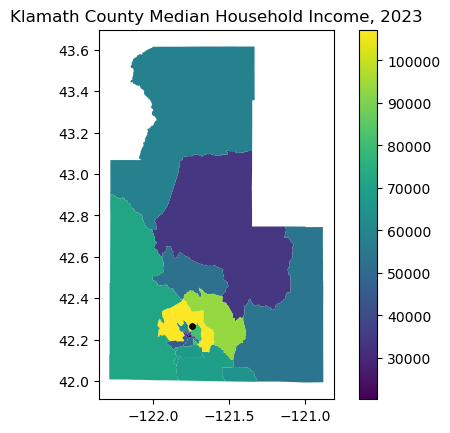

In [140]:
klamathCensusGdf = orTracts.merge(klamathCountyTractsIncome, on='GEOIDFQ', how='inner')

# Plot the result
klamathCensusGdf.plot(column="median_household_income", cmap="viridis", legend=True, categorical=False)
plt.scatter(superfund_coords[0], superfund_coords[1], s=15, c='k')
plt.title("Klamath County Median Household Income, 2023")
plt.savefig("../visualizations/klamath-county-income-2023-map.jpeg")
plt.show()

In [154]:
from shapely.geometry import Point
superfundGdf = gpd.GeoDataFrame({"Name": ["North Ridge Estates"], 'geometry': [Point(superfund_coords)]}, crs=klamathCensusGdf.crs)

m = klamathCensusGdf.explore(
    column='median_household_income',
    cmap='viridis',
    legend=True,
    # tooltip=['col1', 'col2'],
    name='Median Household Income'
)

superfundGdf.explore(
    m=m,
    column="Name",
    color="Black"
)

m
m.save("../visualizations/klamath-county-income-2023-map-folio.html")

# Bexar County - River City Metal Finishing

## Economic Indicators

In [30]:
#iterates through ac5 data,
# I am filtering through Texas and cities
params_tx = {
    'get': 'NAME,B19013_001E',
    'for': 'place:*',
    'in': 'state:48',
    'key': API_key}
acs_tx = acs_df_request(params_tx, (2013, 2024), "acs-2013-2023-texas-cities-income.csv")
acs_tx.tail()

,NAME,B19013_001E,state,place,year
19671,"Zapata Ranch CDP, Texas",106458,48,80722,2023
19672,"Zarate CDP, Texas",-666666666,48,80724,2023
19673,"Zavalla city, Texas",41250,48,80728,2023
19674,"Zephyr CDP, Texas",29543,48,80740,2023
19675,"Zuehl CDP, Texas",68594,48,80836,2023


In [34]:
#data cleaning

#Im renaming the column name to median household income in the past 12months
median_household_tx = acs_tx.rename(columns = {'B19013_001E':'Median Household Income'})
median_household_tx.head(5)

#im turning median income into integers since they're strings
median_household_tx['Median Household Income'] = pd.to_numeric(median_household_tx['Median Household Income'], errors ='coerce')
median_household_tx['year'] = pd.to_numeric(median_household_tx['year'], errors ='coerce')

#getting rid of na values or negative values
invalid_count = (median_household_tx['Median Household Income'] <= 0).sum()
total_count = len(median_household_tx)
print(f"Invalid values: {invalid_count} ({invalid_count / total_count:.2%} of total)")

median_household_tx = median_household_tx[median_household_tx['Median Household Income'] > 0]

#grouping by year to get avg income over time (Hermiston city)
median_household_sanant = median_household_tx[median_household_tx['NAME'] == 'San Antonio city, Texas']
#grouped_herm = median_household_herm.groupby('year')[['Median Household Income']].mean()
#grouped_herm = grouped_herm.reset_index()
grouped_sanant = median_household_sanant

# #grouping by year to get avg income over time (Klamath Falls-near site)
# median_household_kla = median_household[median_household['NAME'] == 'Klamath Falls city, Oregon']
# #grouped_kla = median_household_kla.groupby('year')[['Median Household Income']].mean()
# #grouped_kla = grouped_kla.reset_index()
# grouped_kla = median_household_kla

Invalid values: 2416 (12.28% of total)


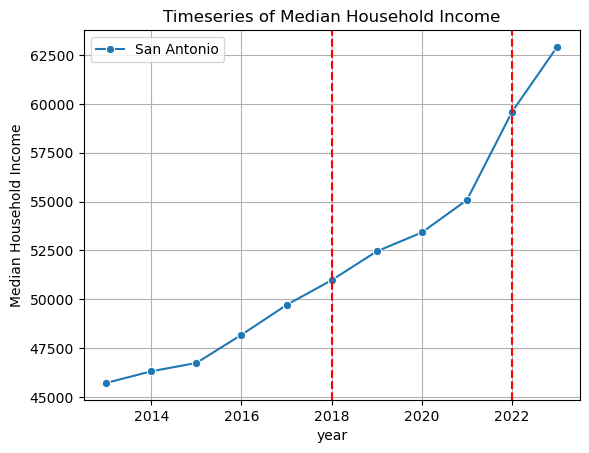

In [36]:
sns.lineplot(data = grouped_sanant, x = 'year', y = 'Median Household Income', marker = 'o', label = 'San Antonio')
# sns.lineplot(data = grouped_herm, x = 'year', y = 'Median Household Income', marker = 'o', label = 'Hermiston City')

plt.title('Timeseries of Median Household Income')
plt.legend()
plt.grid(True)
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2022, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig("../visualizations/sanant-income-2013-2023-plot.jpeg")
plt.show()

## Demographic Indicators

In [37]:
#iterates through ac5 data,
# I am filtering through Oregon and cities

params_ethnicity_tx = {
    'get': 'NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E',
    'for': 'place:*',
    'in': 'state:48',
    'key': API_key}

ethnicity_tx = acs_df_request(params_ethnicity_tx, (2013, 2024), "acs-2013-2023-texas-cities-ethnicity.csv")
ethnicity_tx.tail()

,NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E,state,place,year
19671,"Zapata Ranch CDP, Texas",210,197,54,0,0,48,80722,2023
19672,"Zarate CDP, Texas",104,104,104,0,0,48,80724,2023
19673,"Zavalla city, Texas",598,6,514,0,0,48,80728,2023
19674,"Zephyr CDP, Texas",215,12,204,0,2,48,80740,2023
19675,"Zuehl CDP, Texas",301,133,201,0,0,48,80836,2023


In [38]:
ethnicity_tx = ethnicity_tx.rename(columns ={
    'B03001_001E': 'Total_Pop',
    'B03003_003E': 'Hispanic_or_Latino',
    'B02001_002E': 'White_alone',
    'B02001_003E': 'Black_alone',
    'B02001_005E': 'Asian_alone'
})

eth_column = ['Total_Pop','Hispanic_or_Latino','White_alone','Black_alone','Asian_alone']
for i in eth_column:
    if i in ethnicity_tx.columns:
        ethnicity_tx[i] = pd.to_numeric(ethnicity_tx[i], errors ='coerce')
ethnicity_tx.to_csv(processed_data_dir + "acs-2013-2023-texas-cities-ethnicity-processed.csv")
San_Antonio_ethnicity = ethnicity_tx[ethnicity_tx['NAME'] == 'San Antonio city, Texas']
San_Antonio_ethnicity.head(5)

,NAME,Total_Pop,Hispanic_or_Latino,White_alone,Black_alone,Asian_alone,state,place,year
786,"San Antonio city, Texas",1359033,858684,1028360,92656,32218,48,65000,2013
3411,"San Antonio city, Texas",1385438,877444,1067549,94155,33601,48,65000,2014
3616,"San Antonio city, Texas",1413881,895517,1104754,99220,36394,48,65000,2015
6288,"San Antonio city, Texas",1439358,916055,1134082,102551,39388,48,65000,2016
8367,"San Antonio city, Texas",1461623,935458,1170477,102197,40127,48,65000,2017


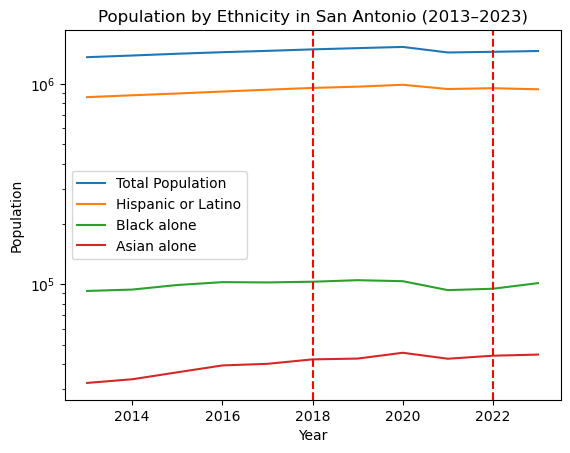

In [39]:
# ethnicity_log = np.log10(Klamath_falls_ethnicity[['Hispanic_or_Latino','White_alone','Black_alone','Asian_alone']])
sns.lineplot(data=San_Antonio_ethnicity, x='year', y='Total_Pop', label='Total Population')
sns.lineplot(data=San_Antonio_ethnicity, x='year', y='Hispanic_or_Latino',label='Hispanic or Latino')
sns.lineplot(data=San_Antonio_ethnicity, x='year', y='Black_alone', label='Black alone')
sns.lineplot(data=San_Antonio_ethnicity, x='year', y='Asian_alone', label='Asian alone')

plt.title('Population by Ethnicity in San Antonio (2013–2023)')
plt.ylabel('Population')
plt.xlabel('Year')
plt.legend()
plt.yscale('log')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2022, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig("../visualizations/san-antonio-city-ethnicity-2013-2023-plot.jpeg")
plt.show()

## Mapping Basics

In [40]:
params_tract = {
    'get': 'GEO_ID,B19013_001E,B25008_002E,B25008_003E',
    'for': ['tract:*', 'county:029'],
    'in': ['state:48', 'county:029'],
    'key': API_key}
bexarCountyTractsIncome = acs_df_request(params_tract, (2023, 2024), "acs-2023-2023-texas-tracts-035-income-tenure.csv")
bexarCountyTractsIncome.rename(columns={'B19013_001E': "median_household_income", 
                            'tract': 'TRACTCE',
                            'GEO_ID': "GEOIDFQ",
                            'B25008_002E': 'owner_occupied_units',
                            'B25008_003E': 'renter_occupied_units'},
                          inplace=True)

bexarCountyTractsIncome['median_household_income'] = pd.to_numeric(bexarCountyTractsIncome['median_household_income'], errors ='coerce')
bexarCountyTractsIncome['year'] = pd.to_numeric(bexarCountyTractsIncome['year'], errors ='coerce')
bexarCountyTractsIncome['owner_occupied_units'] = pd.to_numeric(bexarCountyTractsIncome['owner_occupied_units'], errors ='coerce')
bexarCountyTractsIncome['renter_occupied_units'] = pd.to_numeric(bexarCountyTractsIncome['renter_occupied_units'], errors ='coerce')

In [42]:
txTracts = gpd.read_file(
    f"https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_48_tract.zip"
)

In [70]:
superfund_tx_coords = Point(-98.731875, 29.430489)
superfund_tx_gdf = gpd.GeoDataFrame(data={"Name": ["River City Metal Finishing"], "Listing": ["05/07/2018"], "Completion": ["06/01/2022"]}, geometry=[superfund_tx_coords], crs=txTracts.crs)

In [60]:
bexarCountyTractsIncome.loc[bexarCountyTractsIncome["median_household_income"] == -666666666, "median_household_income"] = 0
bexarCountyTractsIncome.head()

,GEOIDFQ,median_household_income,owner_occupied_units,renter_occupied_units,state,county,TRACTCE,year
0,1400000US48029110100,42823,159,3140,48,029,110100,2023
1,1400000US48029110300,54609,1134,1567,48,029,110300,2023
2,1400000US48029110500,21146,378,2165,48,029,110500,2023
3,1400000US48029110600,20835,542,2000,48,029,110600,2023
4,1400000US48029110700,26806,358,592,48,029,110700,2023


In [78]:
tx_buffer.info()

<class 'geopandas.geoseries.GeoSeries'>
RangeIndex: 1 entries, 0 to 0
Series name: None
Non-Null Count  Dtype   
--------------  -----   
1 non-null      geometry
dtypes: geometry(1)
memory usage: 140.0 bytes


In [94]:
bexarCensusGdf = txTracts.merge(bexarCountyTractsIncome, on='GEOIDFQ', how='inner')
tx_buffer = superfund_tx_gdf.to_crs("EPSG:26943").buffer(4000).to_crs(txTracts.crs)
tx_buffered_superfund = gpd.GeoDataFrame(superfund_tx_gdf, geometry=tx_buffer)
bexarBufferedGdf = gpd.sjoin(bexarCensusGdf, tx_buffered_superfund, how='inner', predicate='intersects')

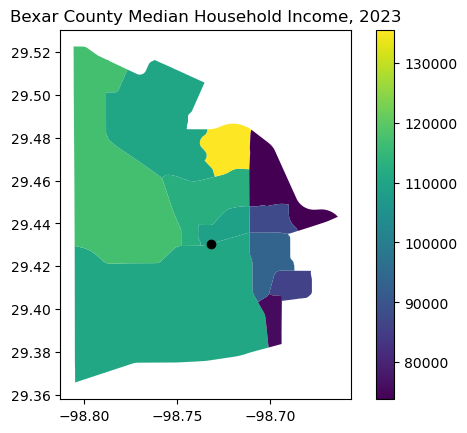

In [95]:
# Plot the result
fig, ax = plt.subplots()
bexarBufferedGdf.plot(ax=ax, column="median_household_income", cmap="viridis", legend=True, categorical=False)
superfund_tx_gdf.plot(ax=ax, color="black")
# plt.scatter(tx_buffer, superfund_tx_coords[1], s=15, c='k')
plt.title("Bexar County Median Household Income, 2023")
plt.savefig("../visualizations/bexar-county-income-2023-map.jpeg")
plt.show()

In [154]:
m = klamathCensusGdf.explore(
    column='median_household_income',
    cmap='viridis',
    legend=True,
    # tooltip=['col1', 'col2'],
    name='Median Household Income'
)

superfundGdf.explore(
    m=m,
    column="Name",
    color="Black"
)

m
m.save("../visualizations/klamath-county-income-2023-map-folio.html")